In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
%matplotlib inline

To visualize a convolutional neural network, we'll draw a graph in code. 

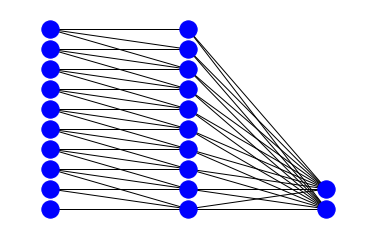

In [8]:
convolve = nx.Graph()
inputs = {i: (0, i) for i in range(0, 10)}
activations = {i+100: (1, i) for i in range(0, 10)}
outputs= {i+1000: (2, i) for i in range(0, 2)}
all = {**inputs, **activations, **outputs}
#and now -- convolutionally connected

def window(items, kernel):
    windows = []
    at = 0
    while at < len(items) + kernel:
        windows.append(items[at:at+kernel])
        at = at + 1
    return windows

for i, w in enumerate(window(list(inputs.keys()), 3)):
    for input in w:
        convolve.add_edge(input, i+100)
for activation in activations:
    for output in outputs:
        convolve.add_edge(activation, output)
nx.draw_networkx_nodes(convolve, all, nodelist=all.keys(), node_color='b')
nx.draw_networkx_edges(convolve, all)
plt.axis('off')
pass


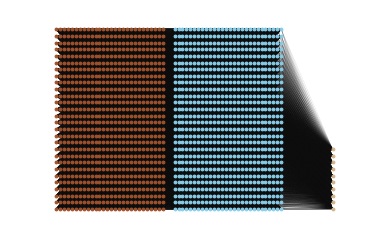

In [5]:
import itertools
mnist = nx.Graph()
pixels = {i: (x, y) for i, (x, y) in enumerate(itertools.product(range(0, 28), range(0, 28)))}
activations = {i+1000: (x+30, y) for i, (x, y) in enumerate(itertools.product(range(0, 28), range(0, 28)))}
digits = {i+2000: (70, i) for i in range(0, 10)}
all = {**pixels, **activations, **digits}
for pixel in pixels:
    for activation in activations:
        mnist.add_edge(pixel, activation)
for activation in activations:
    for digit in digits:
        mnist.add_edge(activation, digit)
nx.draw_networkx_nodes(mnist, pixels, nodelist=pixels.keys(), node_color='sienna', node_size=8)
nx.draw_networkx_nodes(mnist, activations, nodelist=activations.keys(), node_color='skyblue', node_size=8)
nx.draw_networkx_nodes(mnist, digits, nodelist=digits.keys(), node_color='tan', node_size=8)
nx.draw_networkx_edges(mnist, all, width=0.1, alpha=0.5)
plt.axis('off')
pass

What makes a neural network able to learn interesting patterns is the concept of non-linearity. Very literally this means a function that does not generate a straight line.

Very commonly two kinds of non linearity are used -- the relu, and the sigmoid. These non linear 'activation functions' will be used in the layers of our neural network.

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(x, 0)


x = np.arange(-5., 5., 0.2)
plt.subplot(121)
plt.title('sigmoid')
plt.plot(x, sigmoid(x))
plt.subplot(122)
plt.title('relu')
plt.plot(x, relu(x))
pass


And on output, our output classes work best when we can think of them as probabilities that all add up to 1. This way we can tell the best matching prediction made by our neural network.

In [ ]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)
sample_outputs = [1, 2, 5]
softmax(sample_outputs)

In [ ]:
softmax(sample_outputs).sum()

Now with those concepts in mind, let's actually build a dense neural network to learn to recognize handwritten digits. Starting with the training and testing data.

In [ ]:
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Dropout, Flatten
from keras.models import Model

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / np.max(x_train)
x_test = x_test / np.max(x_test)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

And now, using the Keras functional API, stack together layers starting with the input, through Dense and Dropout learning layers, and then on to a final softmax output.

Dropout is a device to help your network not memorize the input. The larger the number of parameters in your model, the larger the chance your model memorizes the input. Dropout is selective forgetting, turning off parts of the model randomly to avoid memorization.

One thing to note here is Flatten. Because our images are two dimensional *x,y* pairs, and our output is one dimension -- a class 0-9, Flatten is needed to reduce the dimensions.


In [ ]:
input_layer = Input(shape=x_train[0].shape)
dense_1 = Dense(32, activation='relu')(input_layer)
dropout_1 = Dropout(0.1)(dense_1)
dense_2 = Dense(32, activation='relu')(dropout_1)
dropout_2 = Dropout(0.1)(dense_2)
flat = Flatten()(dropout_2)
output_layer = Dense(10, activation='softmax')(flat)

model = Model(inputs=[input_layer], outputs=[output_layer])
model.summary()

With the model assembled, we compile it, which prepares the model for execution with a solver. The solver is a mathematical search engine, it works through the possible values of our trainable parameters. This seems like a lot of work -- and it is -- but multiple different solver algorithms exist which prevent the solver from looking at every possible number. 

The trick is the *loss* which is feedback to the solver as to whether it is getting better or worse. Picking the right loss function to work with your network is important, but can be approached as a cookbook.

The loss functions are a bit hard to relate to, so we also have a metric. Accuracy is straightforward, telling you the percentage of the time you model predicted the right answer.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=8,
                    verbose=1,
                    validation_data=(x_test, y_test))

Parameters are numbers found by the solver, inside the model. Hyperparameters are numbers or settings we supply to create the model. Building a better model involves iteration and tuning these hyperparameters. 

Fortunately, we can use another layer of machine learning -- Grid Search -- to work through a set of hyperparameters for us. Grid search uses cross validation, splitting the training data up into folds for training and testing of each hyperparameter combination. After all hyperparameter variants are trained, the original test data is used to validate the final model.


Machine learing often involves a lot of human waiting!

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
import time

In [ ]:
def dense_model(units, dropout):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_shape=(28, 28,)))
    model.add(Dropout(dropout))
    model.add(Dense(units, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

hyperparameters = {
    'epochs': [1],
    'batch_size': [64],
    'units': [32, 64, 128],
    'dropout': [0.1, 0.2, 0.4]
}

model = KerasClassifier(build_fn=dense_model, verbose=0)
start = time.clock()
grid = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=6, verbose=4)
grid_result = grid.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#the KerasClassifier comes back with the labels 0-9, so we use argmax
#to turn our one-hot encoding into 0-9 digit labels
y_true, y_pred = np.argmax(y_test, axis=1), grid.predict(x_test)
print()
print(classification_report(y_true, y_pred))
print()
print(time.clock() - start)
